In [2]:
import torch
from fastai.text import *
from pathlib import Path
import news_utils.plot

import pymongo
from collections import defaultdict

import sklearn.metrics

# print all available databases
client = pymongo.MongoClient('localhost', 27017)
cursor = client.list_databases()
for db in cursor:
    print(db)
    
    
import altair as alt
alt.renderers.enable('notebook')

{'name': '10000', 'sizeOnDisk': 270336.0, 'empty': False}
{'name': '10000_cl', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_clagreement', 'sizeOnDisk': 253952.0, 'empty': False}
{'name': '10000_cl_claudience', 'sizeOnDisk': 368640.0, 'empty': False}
{'name': '10000_cl_clcontroversial', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_cldisagreement', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_clinformative', 'sizeOnDisk': 258048.0, 'empty': False}
{'name': '10000_cl_clmean', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_clpersuasive', 'sizeOnDisk': 360448.0, 'empty': False}
{'name': '10000_cl_clsentiment', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_cltopic', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_ner', 'sizeOnDisk': 274432.0, 'empty': False}
{'name': '10000_ner_cl', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_ner_cl_clagreement', 'sizeOnDisk': 253952.0, 'empty': False}
{'name': '10000_ner_

RendererRegistry.enable('notebook')

In [3]:
def get_mets(db, conf=None):
    mydb = client[db]
    res = mydb["metrics"].aggregate([{
        "$match": {"name": 'kappa_score'}  # only consider metric
    },
        {"$unwind": "$values"},
        {"$group":
         {'_id': '$_id',
          'val': {'$max': "$values"}, 'run_id' : { '$first': '$run_id' }}
         },  # find min values
        {"$sort": {"val": -1}}  # sort
    ])
    
    if not conf is None:
        runs = mydb['runs'].find(conf)
        runs  = [r['_id'] for r in list(runs)]
        res = [r for r in res if r['run_id'] in runs]

    best = list(res)[0]

    epoch = None
    max_epochs = 0

    for x in mydb['metrics'].find({'run_id': best['run_id'], 'name': 'kappa_score'}):
        max_epochs = len(x['values'])
        for i, v in enumerate(x['values']):
            if v == best['val'] and epoch is None:
                epoch = i + 1

    for x in mydb['metrics'].find({'run_id': best['run_id'], 'name': 'F1_macro'}):
        f1_macro = x['values'][epoch - 1]

    for x in mydb['metrics'].find({'run_id': best['run_id'], 'name': 'accuracy'}):
        f1_micro = x['values'][epoch - 1]
    
    run = list(mydb['runs'].find({'_id': best['run_id']}))[0]
        
    mod = ''
    if 'mod' in  run['config']:
        mod= run['config']['mod']
        
    return best['val'], f1_micro, f1_macro, epoch, max_epochs, run['config']['exp_id'], run['config']['drop_mult'], mod

In [4]:
all_cols =  ['claudience', 'clpersuasive', 'clsentiment', 'clagreement', 'cldisagreement', 'clinformative', 'clmean', 'clcontroversial', 'cltopic']

In [5]:
choos_cat = 'dat_false_par_true_hea_false30000_cl_cltopic'

In [6]:
get_mets(db=choos_cat, conf={})

(0.29064828157424927,
 0.7066895365715027,
 0.6444018790596141,
 40,
 61,
 '2019_ 2_26_16_36_45_362323',
 1.0,
 '')

In [7]:
model_id = '2019_ 2_26_16_36_45_362323'

In [8]:
p = list(Path('/home/group7/data/ynacc_proc').glob(f'**/{model_id}.pth'))[0]

In [9]:
p_fixed = '/'.join(p.parts[:-2])[1:]

In [10]:
exp = p.parts[-3]

In [11]:
data_lm = TextLMDataBunch.load(Path('/mnt/data/group07/johannes/ynacc_proc/proper_baseline/exp/' + exp))

In [12]:
def setup_data(clas):
#    UT = Path('~/data/ynacc_proc/proper_threads/data/cls/' + args.exp)
#     UT = Path('~/data/ynacc_proc/proper_threads/data/cls/only_threads_unlimited_30000_cut')
    UT = Path('~/data/ynacc_proc/proper_baseline/cls/dat_false_par_true_hea_false')

    
    data_clas_train = pd.read_csv(UT/'train.csv')
    data_clas_val = pd.read_csv(UT/'val.csv')
    
    print(data_clas_val.shape)

    data_clas_train = data_clas_train[[clas, 'text_proc']]
    data_clas_val = data_clas_val[[clas, 'text_proc']]

    data_clas_train = data_clas_train.dropna()
    data_clas_val = data_clas_val.dropna()

    data_clas_train[clas] = data_clas_train[clas].astype(int)
    data_clas_val[clas] = data_clas_val[clas].astype(int)

    data_clas = TextClasDataBunch.from_df(p_fixed, data_clas_train, data_clas_val,
                                          vocab=data_lm.train_ds.vocab, bs=64, text_cols=['text_proc'], label_cols=[clas],tokenizer=Tokenizer(cut_n_from_behind=1398))
    return data_clas

In [13]:
data = setup_data('cltopic')

In [14]:
del data_lm

In [15]:
learn = text_classifier_learner(data).load(p.stem)

hidden:  0.3
input:  0.4
embed:  0.05
weight:  0.5


SankeyWidget(links=[{'source': 'true 0', 'target': 'pred 0', 'type': 'cor', 'value': 79}, {'source': 'true 0',…

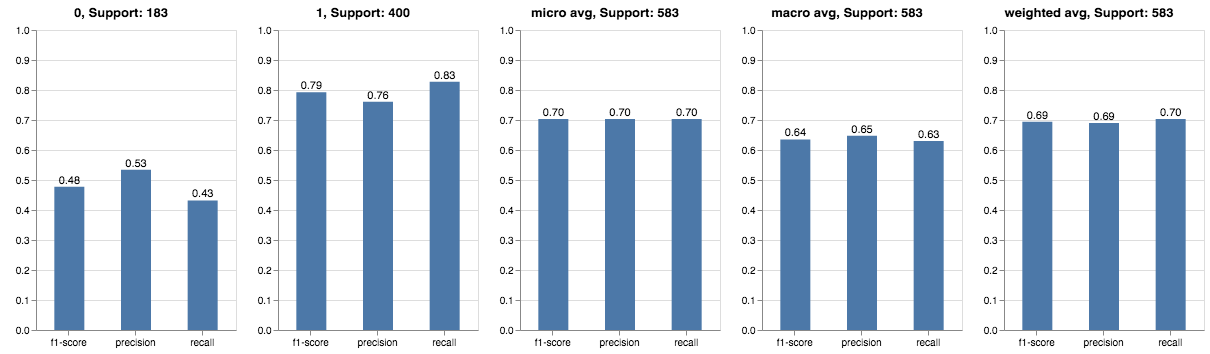

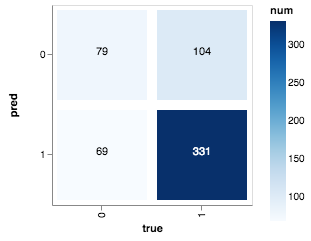

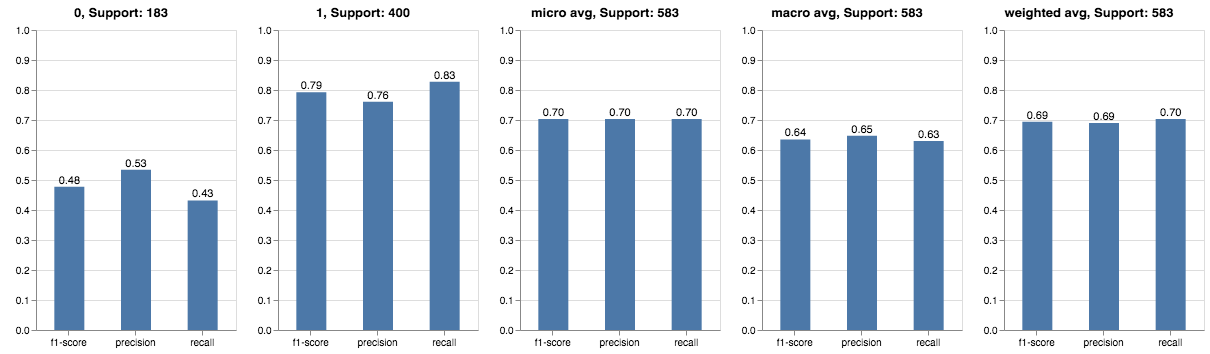

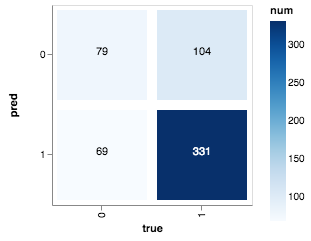

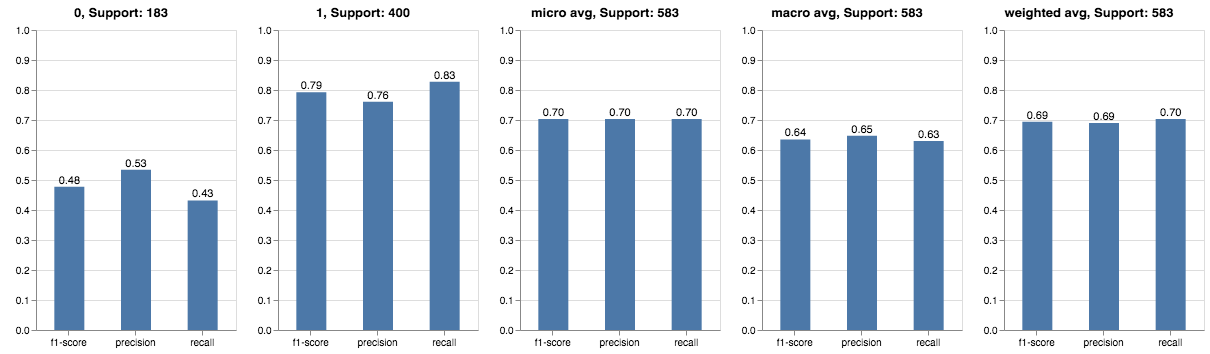

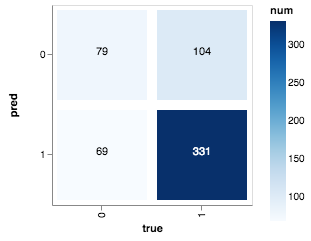

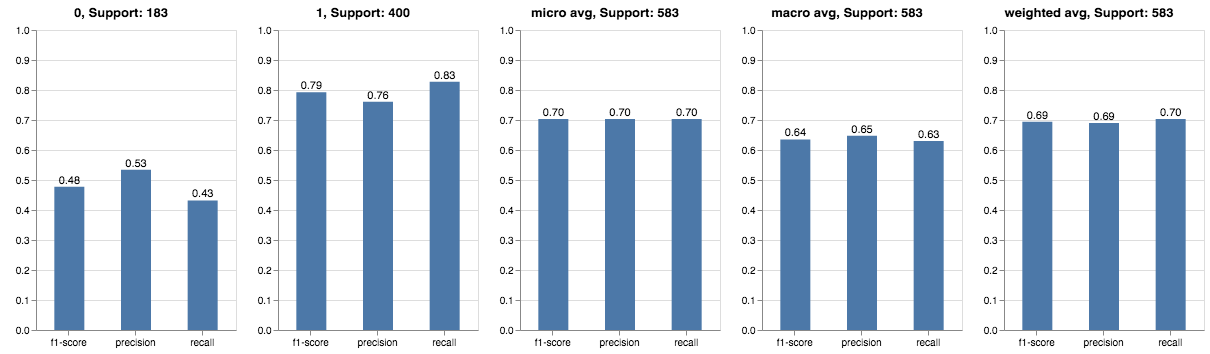

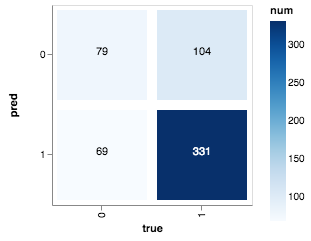

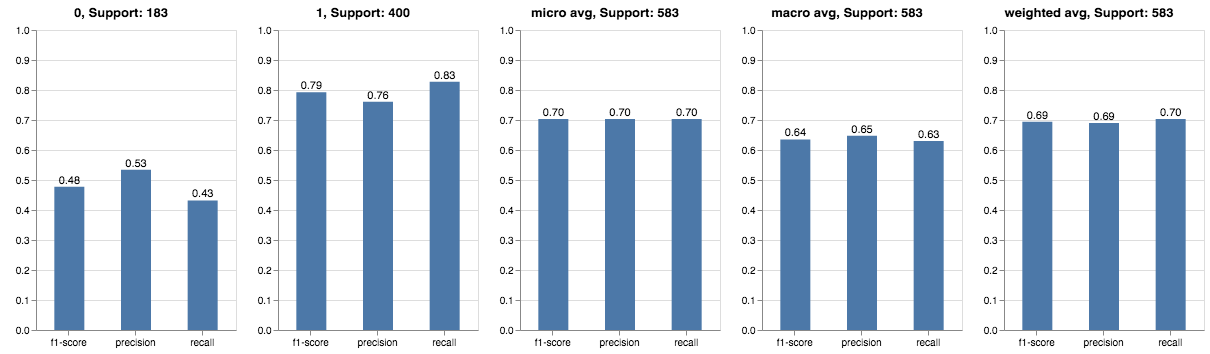

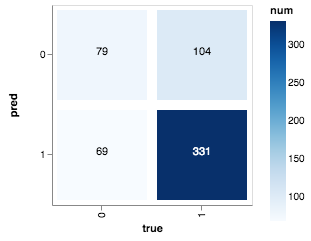

In [16]:
news_utils.plot.all(learn)

In [17]:
preds, y_true = learn.get_preds(ordered=True)

In [18]:
 _, y_pred = preds.max(dim=1)

In [19]:
str(learn.data.valid_ds[0][0])

'xxbos xxmaj mike , i do not know how old you are , but at one time there were moral standards of decency in this country . xxmaj most women that became teachers were usually strict moral beings . xxmaj it has always been men who have struggled thinking with the small head versus using the big head . xxmaj it is just a sham , how xxunk these young female teachers have become , with no morale guidance or self discipline . xxreplysep xxreply_false'

In [20]:
lens = []
lens_true = []

for i, d in enumerate(learn.data.valid_ds):
    if len(str(d[0])) > 600:
        continue
    if y_true[i] != y_pred[i]:
        lens.append(len(str(d[0])))
    else:
        lens_true.append(len(str(d[0])))

In [30]:
d_l = [x//20 for x in lens]
d_lt = [x//20 for x in lens_true]

for i in range(1, 20):
    print(str(i*20) + '-' + str((i+1)*20), d_lt.count(i) / (d_lt.count(i) + d_l.count(i)), ' Context-agnostic')

20-40 0.0  Context-agnostic
40-60 0.44  Context-agnostic
60-80 0.7142857142857143  Context-agnostic
80-100 0.6226415094339622  Context-agnostic
100-120 0.7209302325581395  Context-agnostic
120-140 0.6956521739130435  Context-agnostic
140-160 0.6829268292682927  Context-agnostic
160-180 0.4857142857142857  Context-agnostic
180-200 0.6176470588235294  Context-agnostic
200-220 0.7272727272727273  Context-agnostic
220-240 0.4  Context-agnostic
240-260 0.6666666666666666  Context-agnostic
260-280 0.8666666666666667  Context-agnostic
280-300 0.7647058823529411  Context-agnostic
300-320 0.8888888888888888  Context-agnostic
320-340 0.9230769230769231  Context-agnostic
340-360 0.7692307692307693  Context-agnostic
360-380 0.8  Context-agnostic
380-400 0.6363636363636364  Context-agnostic


In [22]:
d_l

[8,
 9,
 6,
 4,
 3,
 2,
 3,
 1,
 6,
 14,
 7,
 9,
 4,
 12,
 11,
 7,
 10,
 7,
 8,
 25,
 5,
 6,
 4,
 9,
 11,
 9,
 7,
 8,
 2,
 3,
 4,
 2,
 8,
 13,
 5,
 5,
 17,
 7,
 7,
 8,
 5,
 4,
 4,
 5,
 3,
 8,
 8,
 6,
 8,
 5,
 4,
 11,
 4,
 5,
 3,
 1,
 4,
 4,
 11,
 14,
 11,
 8,
 7,
 9,
 8,
 9,
 9,
 10,
 19,
 8,
 5,
 6,
 6,
 20,
 11,
 7,
 7,
 11,
 4,
 14,
 3,
 8,
 9,
 8,
 2,
 6,
 9,
 17,
 19,
 7,
 2,
 20,
 15,
 9,
 7,
 8,
 1,
 3,
 4,
 9,
 3,
 7,
 6,
 13,
 11,
 2,
 4,
 8,
 4,
 8,
 9,
 4,
 21,
 12,
 10,
 14,
 2,
 4,
 2,
 17,
 16,
 7,
 6,
 12,
 4,
 19,
 8,
 2,
 3,
 23,
 19,
 22,
 11,
 10,
 5,
 11,
 6,
 2,
 2,
 2,
 1,
 6,
 6,
 5,
 10,
 6,
 8,
 12,
 6,
 4,
 3,
 29,
 3,
 4,
 20,
 11,
 11,
 5,
 2,
 5,
 3,
 3,
 10,
 9,
 4,
 2,
 18,
 29,
 3]

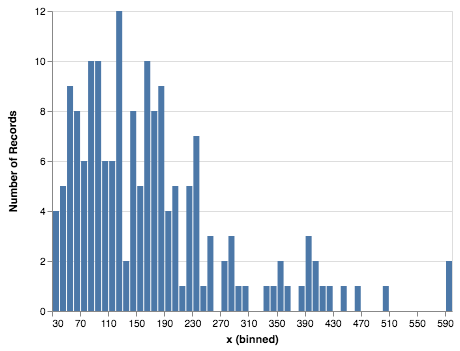

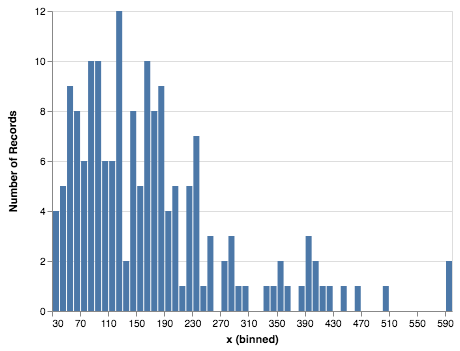

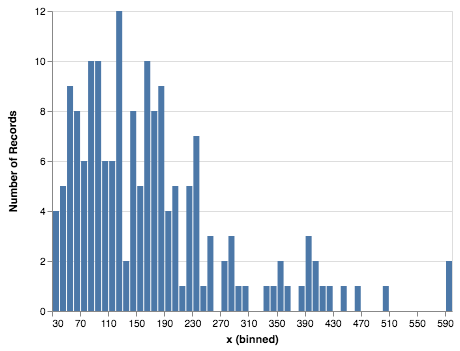

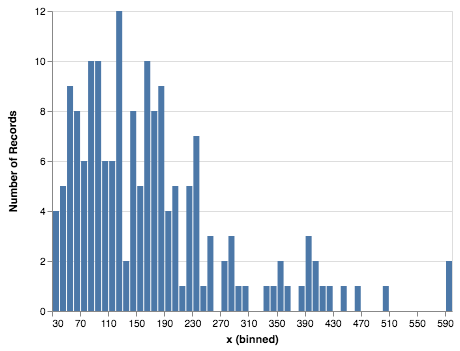

In [20]:
alt.Chart(pd.DataFrame({'x': lens})).mark_bar().encode(
    alt.X("x:Q", bin=alt.Bin(maxbins=60)),
    y='count()',
)

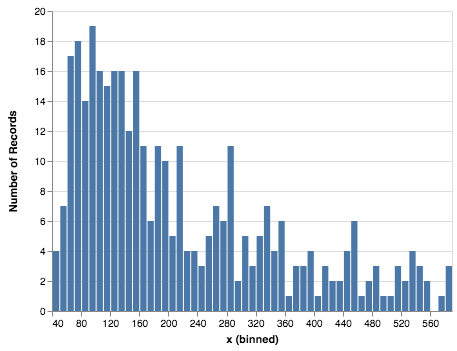

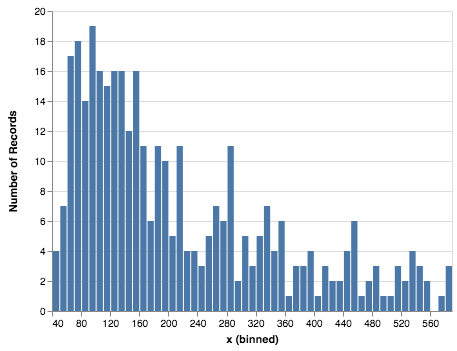

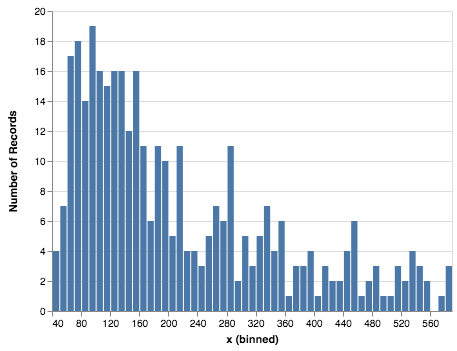

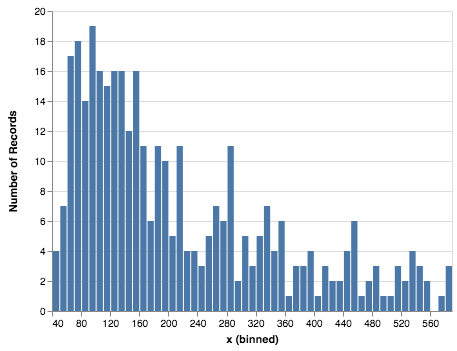

In [21]:
alt.Chart(pd.DataFrame({'x': lens_true})).mark_bar().encode(
    alt.X("x:Q", bin=alt.Bin(maxbins=60)),
    y='count()',
)

In [22]:
root_i = []
other_i = []

for i, d in enumerate(learn.data.valid_ds):
    if len(str(d[0])) > 100:
#     if 'xxreply_false' in str(d[0]):
        root_i.append(i)
    else:
        other_i.append(i)

In [23]:
sklearn.metrics.classification_report([x for i, x in enumerate(y_true) if i in root_i], [x for i, x in enumerate(y_pred) if i in root_i], output_dict=True)

{'0': {'precision': 0.5797101449275363,
  'recall': 0.3053435114503817,
  'f1-score': 0.4,
  'support': 131},
 '1': {'precision': 0.7617801047120419,
  'recall': 0.909375,
  'f1-score': 0.8290598290598291,
  'support': 320},
 'micro avg': {'precision': 0.7339246119733924,
  'recall': 0.7339246119733924,
  'f1-score': 0.7339246119733924,
  'support': 451},
 'macro avg': {'precision': 0.6707451248197891,
  'recall': 0.6073592557251909,
  'f1-score': 0.6145299145299146,
  'support': 451},
 'weighted avg': {'precision': 0.7088950387879395,
  'recall': 0.7339246119733924,
  'f1-score': 0.7044326946765972,
  'support': 451}}

In [24]:
sklearn.metrics.classification_report([x for i, x in enumerate(y_true) if not i in root_i], [x for i, x in enumerate(y_pred) if not i in root_i], output_dict=True)

{'0': {'precision': 0.4936708860759494,
  'recall': 0.75,
  'f1-score': 0.5954198473282444,
  'support': 52},
 '1': {'precision': 0.7547169811320755,
  'recall': 0.5,
  'f1-score': 0.6015037593984962,
  'support': 80},
 'micro avg': {'precision': 0.5984848484848485,
  'recall': 0.5984848484848485,
  'f1-score': 0.5984848484848485,
  'support': 132},
 'macro avg': {'precision': 0.6241939336040124,
  'recall': 0.625,
  'f1-score': 0.5984618033633703,
  'support': 132},
 'weighted avg': {'precision': 0.6518806406554197,
  'recall': 0.5984848484848485,
  'f1-score': 0.5991070667647607,
  'support': 132}}

In [25]:
learn.data.valid_ds[2]

(Text xxbos xxmaj but , the genders are important . xxmaj the penalty for the crime should be related to any damage done . xxmaj in the case of a female teacher and a male student less damage is done . xxmaj if one of my high school teachers hit on me i would have said yes right away . xxmaj if i found out one of my male friends was doing , a teacher i would have high - xxunk him . xxmaj yes , she has issues . xxmaj but , a double standard exist because men and women are different . xxmaj you can act like it 's the same thing all day if you want , but that does n't make it true . xxmaj males just want to have sex . xxmaj next time you watch some reality cop show just note how many men get caught , and arrested , for soliciting a prostitute verses women . i absolutely guarantee the ratio is 00,000 to 0 or even greater . xxmaj this is even though men know that prostitutes carry diseases , soliciting a prostitute is illegal , you are paying for sex and it 's devoid of any genuine intimacy

In [26]:
def cut(text):
    start_token = 'xx_comment_start'
    end = 'xx_comment_end xx_thread_end'
    i = text.rindex(start_token)
    return text[:i -1], text[i + len(start_token):-len(end)]

In [27]:


idx = 0
conf = []
for i, (x, y) in enumerate(zip(res[0], res[1])):
    if np.argmax(x) != y:
        conf.append([i, max(x), y.item()])

NameError: name 'res' is not defined

In [ ]:
learn.data.valid_ds[0][0].text